In [1]:
import os, sys
sys.path.append(os.environ['WORK_DIR'])
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
from trade.helpers.helper import optionPV_helper 
from scipy.optimize import minimize 
from py_vollib.black_scholes_merton import black_scholes_merton
from trade.helpers.helper import time_distance_helper
import warnings
from pprint import pprint
import ipywidgets as widgets 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def TotalVarSVIJW(S0, K, t, v, psi, p, c, v_tilde): 
    k = np.log(K / S0)
    w= v * t
    b = np.sqrt(w) / 2 * (c + p)
    rho = 1 - p * np.sqrt(w) / b
    #beta has to be in [­1, +1]
    beta = rho - 2 * psi * np.sqrt(w) / b
    alpha = np.sign(beta) * np.sqrt(1 / beta**2 - 1)
    m = (v - v_tilde) * t / (b * (- rho + np.sign(alpha) * np.sqrt(1 + alpha**2) - alpha * np.sqrt(1 - rho**2)))
    sigma = alpha * m
    a = v_tilde * t - b * sigma * np.sqrt(1 - rho**2)
    if (m == 0): sigma = (w - a) / b
    return (a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))) ## Total Variance. Result should be transformed as so: sqrt(result/t)

## Estimation of Params

In [6]:
Strikes = range(49, 202)
S0 = 100
t = .10
v = 0.3**2 
psi =-0.10
p = .40
c = 1.
v_tilde = 0.18**2
IV_ = [(TotalVarSVIJW(S0, K, t, v, psi, p, c, v_tilde) / t)**0.5 for K in Strikes]
params = [v, psi, p, c, v_tilde] 
params

[0.09, -0.1, 0.4, 1.0, 0.0324]

### Estimation of V


In [7]:
KATM = 100.0
IV_ATM = (TotalVarSVIJW(S0, KATM, t, v, psi, p, c, v_tilde)/t)**0.5 
v_est = IV_ATM**2 #v from ATM vol
print("Real v: " + str(np.round(v, 3))) 
print("Estimated v: " + str(np.round(v_est, 3)))

Real v: 0.09
Estimated v: 0.09


## SVI Caliberation to Market Prices

In [8]:
def CallPrice(S, sigma, K, T, r):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5) 
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = math.exp(-r * T)
    price=S * n1 - K * DF * n2
    return price

r = 0.05 #Risk­Free Interest Rate
S0 = 100 #Asset Price
IV_ = [.36,.28, .26, .245, .24, .242, 0.248] #Black­Scholes Implied Vol 
K = [90, 95, 97.5, 100, 102.5, 105, 110] #Strike Prices
T = [.25] * 7 #Maturity
Price = [CallPrice(S0, IV_[i], K[i], T[i], r) for i in range(len(T))]

# Minimizing Model

In [9]:
def MSE_Price_SVIJW(params):
    MSE_Price = 0
    for i in range(len(T)):
        MSE_Price = MSE_Price + (CallPrice(S0, (TotalVarSVIJW(S0, K[i], T[i], *params)/T[i])**.5, K[i], T[i], r) - Price[i])**2 
    return MSE_Price / len(T)


def MSE_IV_SVIJW(params): 
    MSE_IV = 0
    for i in range(len(T)):
        SVIJW_IV = (TotalVarSVIJW(S0, K[i], T[i], *params) / T[i])**.5 
        MSE_IV = MSE_IV + (SVIJW_IV - IV_[i])**2
    return MSE_IV / len(T)


cons=(
{'type': 'ineq', 'fun': lambda x: x[0] - 0.00001}, #v > 0 
{'type': 'ineq', 'fun': lambda x: x[0] - x[4]}, #v >= v_tilde
{'type': 'ineq', 'fun': lambda x: x[4] - 0.00001}, #v_tilde > 0 
{'type': 'ineq', 'fun': lambda x: x[2]}, #p >= 0
{'type': 'ineq', 'fun': lambda x: x[3]}, #c >= 0
)

In [10]:
IV = interp1d(K, IV_)
minIV = min(IV_)
n = len(IV_)
t = T[0]
params[0] = IV(100)**2 #v from ATM vol
params[1]  = (IV(101) - IV(99))/2*100*t**0.5 # PSI is skew of the ATM. (101-99)/2 * 100 * sqrt(t)
params[2], params[3] = 10, 10
params[4] = minIV**2
params #atm vol, atm skew, slope of left wing, slope of right, min vol 

[0.060024999999999995, -0.20000000000000018, 10, 10, 0.0576]

In [11]:
#Minimisation MSE between Market and Model Prices
warnings.filterwarnings('ignore')
result = minimize(MSE_Price_SVIJW, params, constraints = cons, method = 'SLSQP',tol=1e-10) 
new_params = result['x']
new_params

array([ 0.06072465, -0.17363453, 21.39207914,  0.8957227 ,  0.0575657 ])

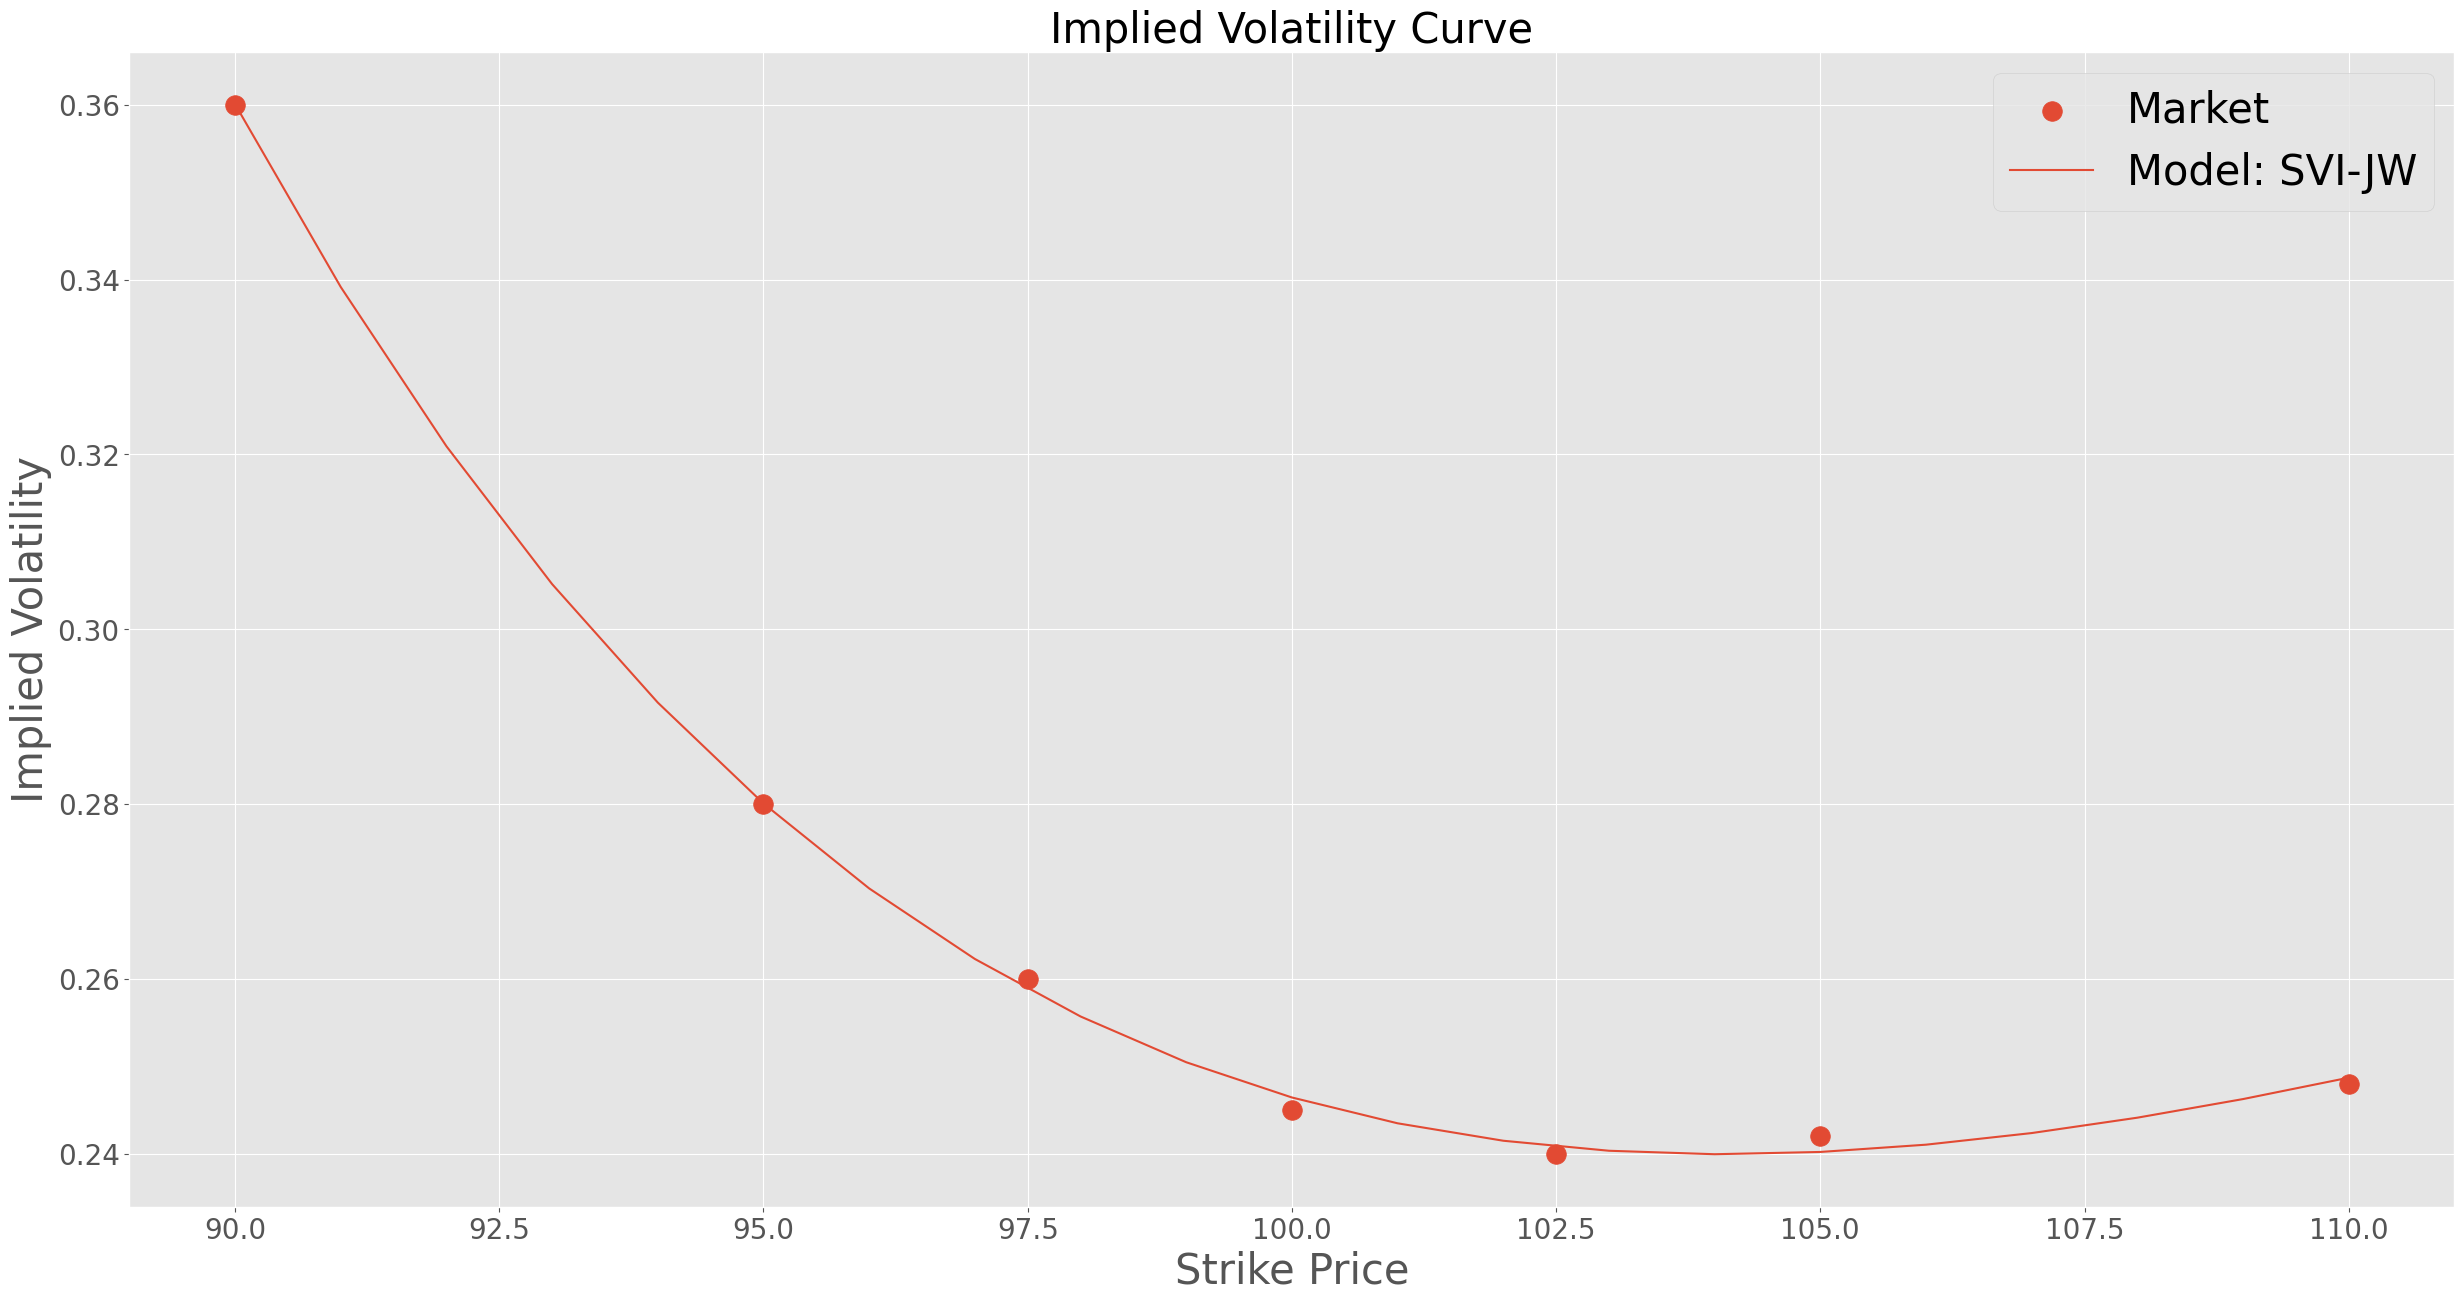

In [12]:
S0 = 100
r = 0.05
Kbis = range(90, 111)
SVIJW_IV = [(TotalVarSVIJW(S0, Kbis[i], T[0], *new_params)/t)**.5 for i in range(len(Kbis))]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(K, IV_, label="Market", s = 200) 
axs.plot(Kbis, SVIJW_IV, label="Model: SVI-JW") 
axs.set_title('Implied Volatility Curve', fontsize = 30,) 
axs.set_xlabel('Strike Price', fontsize = 30) 
axs.set_ylabel('Implied Volatility', fontsize = 30) 
axs.tick_params(axis='x', labelsize = 20) 
axs.tick_params(axis='y', labelsize = 20) 
axs.legend(fontsize=30)
plt.show()

# ***Standardize for Quant Tools***

In [3]:
tick = 'NVDA'
chain = pd.read_csv(f'/Users/chiemelienwanisobi/Documents/GitHub/stop-loss-script/BACKTEST/OptionBacktest/{tick}_Chain.csv')
chain.DTE.unique()

array([  3,  10,  17,  24,  31,  38,  52,  87, 115, 150, 178, 205, 269,
       325, 360, 451, 479, 632, 815, 843])

In [4]:
chain = pd.read_csv(f'/Users/chiemelienwanisobi/Documents/GitHub/stop-loss-script/BACKTEST/OptionBacktest/{tick}_Chain.csv')
# (chain['right'] == right) &
right, price_date, dte = 'P', '2024-09-24', 843
chain = chain[ (chain['DTE'] == dte) & (chain['right'] == right) & (chain['vol'] > 0)]
vol = chain['vol'].values
strike = chain['strike'].values
price = chain['price'].values
spot = chain['Spot'].values[0]
r = chain['r'].values[0]
q = chain['q'].values[0]
T = [chain['DTE'].values[0]/365]* len(strike)
expiration = str(chain['expiration'].values[0])
expiration
chain

,expiration,DTE,strike,right,root,Spot,r,q,build_date,ticker,price,vol,moneyness
3398,2027-01-15,843,5.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,0.085,0.921540,0.041367
3400,2027-01-15,843,15.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,0.220,0.675341,0.124100
3401,2027-01-15,843,20.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,0.435,0.650356,0.165467
3402,2027-01-15,843,25.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,0.705,0.625131,0.206834
3403,2027-01-15,843,30.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,1.035,0.602277,0.248201
3405,2027-01-15,843,50.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,3.525,0.555905,0.413668
3408,2027-01-15,843,60.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,5.675,0.547924,0.496401
3410,2027-01-15,843,65.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,6.925,0.543522,0.537768
3412,2027-01-15,843,70.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,8.300,0.539334,0.579135
3414,2027-01-15,843,75.0,P,True,120.870003,0.04495,0.000232,2024-09-24,NVDA,9.925,0.538596,0.620501


## Volatility Curve with SVI Parameterization

In [5]:

def VolSVI(S0, K, T, a, b, rho, sigma, m):
    k = np.log(K / S0)
    v = np.sqrt((a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))) / T)
    return v


# Black Scholes Call Price
def CallPrice(S, sigma, K, T, r, q):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5) 
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = math.exp(-r * T)
    y = math.exp(-q * T)
    price = S * y * n1 - K * DF * n2
    return price

def PutPrice(S, sigma, K, T, r, q):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5) 
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(-d1)
    n2 = norm.cdf(-d2)
    DF = math.exp(-r * T)
    y = math.exp(-q * T)
    price = K * DF * n2 - S * y * n1 
    return price



IV_ = chain['vol'].values.tolist()
K = chain['strike'].values.tolist()
chain_price = chain['price'].values.tolist()
S0 = chain['Spot'].values[0]
r = chain['r'].values[0]
q = chain['q'].values[0]
t = T[0]
T = [chain['DTE'].values[0]/365]* len(strike)
if right == 'C':
    Price = [CallPrice(S0, IV_[i], K[i], T[i], r, q) for i in range(len(T))] ## List of prices for each strike price
else:
    Price = [PutPrice(S0, IV_[i], K[i], T[i], r, q) for i in range(len(T))]
# Price = [CallPrice(S0, IV[i], K[i], T[i], r, q) for i in range(len(T))] ## List of prices for each strike price
bsm_price = [black_scholes_merton('c', S0, K[i], T[i], r, IV_[i], q) for i in range(len(T))] ## List of prices for each strike price
Price = Price
# Price
T[0], t,  S0, spot

(2.3095890410958906,
 2.3095890410958906,
 120.87000274658205,
 120.87000274658205)

## Mean-Squared Error Minimisation Btwn Market & Model Prices


In [6]:


def MSE_Price_SVIJW(params):
    MSE_Price = 0
    for i in range(len(T)):
        if right == 'C':
            ## With SJW minimization, we recieve TotalVarSVIJW
            ## To transform and use in the CallPrice/PutPrice function, we need to divide by T and take the square root
            MSE_Price = MSE_Price + (CallPrice(S0, (TotalVarSVIJW(S0, K[i], T[i], *params)/T[i])**.5, K[i], T[i], r, q) - Price[i])**2

        else:
            MSE_Price = MSE_Price + (PutPrice(S0, (TotalVarSVIJW(S0, K[i], T[i], *params)/T[i])**.5, K[i], T[i], r, q) - Price[i])**2
            
    return MSE_Price / len(T)


def MSE_IV_SVIJW(params): 
    MSE_IV = 0
    for i in range(len(T)):
        svijw_iv = (TotalVarSVIJW(S0, K[i], T[i], *params) / T[i])**.5 
        MSE_IV = MSE_IV + (svijw_iv - IV_[i])**2
    return (MSE_IV / len(T))


def MSE_Price_SVIJW(params, T, S0, K, r, q, Price, right):
    """
    Calculate the mean squared error (MSE) for given parameters.
    
    Arguments:
    - params: Parameters to be optimized.
    - T: Array of time to maturities.
    - S0: Spot price.
    - K: Array of strike prices.
    - r: Risk-free rate.
    - q: Dividend yield.
    - Price: Observed market prices.
    - right: 'C' for call, 'P' for put.
    
    Returns:
    - MSE_Price: Mean squared error between model and market prices.
    """
    MSE_Price = 0
    for i in range(len(T)):
        total_variance = TotalVarSVIJW(S0, K[i], T[i], *params) / T[i]  # Compute total variance
        implied_vol = total_variance**0.5  # Compute implied volatility
        
        if right == 'C':  # Call option
            model_price = CallPrice(S0, implied_vol, K[i], T[i], r, q)
        else:  # Put option
            model_price = PutPrice(S0, implied_vol, K[i], T[i], r, q)
        
        # Compute squared error
        MSE_Price += (model_price - Price[i])**2
    
    return MSE_Price / len(T)  # Return mean squared error


def MSE_IV_SVIJW(params, T, S0, K, IV_):
    """
    Calculate the mean squared error (MSE) for implied volatility (IV) using SVI-JW.

    Arguments:
    - params: Parameters to be optimized.
    - T: Array of time to maturities.
    - S0: Spot price.
    - K: Array of strike prices.
    - IV_: Observed implied volatilities.
    
    Returns:
    - MSE_IV: Mean squared error between model IV and observed IV.
    """
    MSE_IV = 0
    alpha = 10/np.std(np.log(np.array(K)/spot))**2
    for i in range(len(T)):
        
        # Compute model implied volatility using SVI-JW
        svijw_iv = (TotalVarSVIJW(S0, K[i], T[i], *params) / T[i])**0.5
        w = (1/(1+(np.log(K[i]/spot)**2 * alpha)))
        # print(w, K[i])
        # Add the squared error
        MSE_IV += (svijw_iv - IV_[i])**2 #* w
    # Return the mean squared error
    return MSE_IV / len(T)


all_guesses = []
def save_guesses(x):
    all_guesses.append(x)

cons=(
{'type': 'ineq', 'fun': lambda x: x[0] - 0.00001}, #v > 0 
{'type': 'ineq', 'fun': lambda x: x[0] - x[4]}, #v >= v_tilde
{'type': 'ineq', 'fun': lambda x: x[4] - 0.00001}, #v_tilde > 0 
{'type': 'ineq', 'fun': lambda x: x[2]}, #p >= 0
{'type': 'ineq', 'fun': lambda x: x[3]}, #c >= 0
)

bounds = [
    (0.00001, 10),  # x[0] (arbitrary upper bound to limit search space)
    (0, 10),        # x[1] (no constraint specified, adjust as needed)
    (0, 10),        # x[2] (p >= 0)
    (0, 10),        # x[3] (c >= 0)
    (0.00001, 10),  # x[4] (v_tilde > 0)
]




## Producing Slope of Wings

In [8]:
IV = interp1d(K, IV_)
l=  abs((IV(min(K)) - IV(100))/2*t*100**0.5)
r = abs((IV(100) - IV(150))/2*t*100**0.5)
adj_k = K#[1:-1]
atm_iv = IV(spot)
slope_min = (((IV(min(adj_k))*np.exp(0.01) - IV(min(adj_k)))/0.02) * 1/(atm_iv)**.5)/2
slope_max = (((IV(max(adj_k)) - IV(max(adj_k))*np.exp(-0.01))/0.02) * 1/(atm_iv)**.5)/2
l, r
slope_min, slope_max

(0.31620270358030805, 0.2042544619815078)

In [9]:
slope_scaling_min = ((IV(min(K))*100*2*t)/ (IV(spot)*100*2*t))

slope_scaling_max = ((IV(max(K))*100*2*t)/ (IV(spot)*100*2*t))

slope_scaling_min, slope_scaling_max

(1.7186623870196904, 1.1213456199542662)

In [16]:

minIV = min(IV_)
n = len(IV_)
t = T[0]
params=[0,0,0,0,0]
params[0] = IV(spot)**2 #v from ATM vol
if right == 'C':
    params[1]  = ((IV(spot+1) - IV(spot-1))/2*100*t**0.5) # PSI is skew of the ATM. (101-99)/2 * 100 * sqrt(t)
else:
    params[1]  = ((IV(spot-1) - IV(spot+1))/2*100*t**0.5)
params[2], params[3] = 1,1.6
# params[2], params[3] = l*100, r*1
# params[2], params[3] = slope_min*slope_scaling_min, slope_max*slope_scaling_max
# params[2], params[3] = left_wing_slope/2, right_wing_slope/2
params[4] = minIV**2
params #atm vol, atm skew, slope of left wing, slope of right, min vol 
# [v, psi, p, c, v_tilde]

[0.28750596719727306, -0.22330314551648, 1, 1.6, 0.2815813645885653]

In [17]:
warnings.filterwarnings('ignore')
from copy import deepcopy
min_func = MSE_IV_SVIJW
method = 'L-BFGS-B' if right == 'C' else 'SLSQP'
method = 'SLSQP' 
print('Usimg method: ' + method, 'for ' + right + ' options')
result = minimize(min_func, params, constraints=cons, method = method, tol = 1e-10, args=(deepcopy(T), deepcopy(S0), deepcopy(K), deepcopy(IV_)), callback=save_guesses) ## Minimize the MSE_Price_SVI function
## Too fit to Price, it's better to use theoritical price than market price
new_params = result['x']

print('Params:  ' + str(new_params.tolist()))
print('MSE: ' + str(min_func(new_params, T, S0, K, IV_)))

Usimg method: SLSQP for P options
Params:  [0.2782601144955492, -0.00822403060304945, 1.0325904825732073, 1.5848812817130633, 0.27812477015323434]
MSE: 0.00044492979305208147


In [1262]:
0.00400392388277186**0.5, minIV

(0.06327656661649603, 0.1403922451179169)

In [1263]:
chain.vol.min()

0.1403922451179169


With skew aligned to C
Params:  [0.036444479446445334, -0.025097206294511867, 1.8948440849254535, 1.7434885230170074, 0.036274103128823655]
MSE: 0.0008112145002034027

Params:  [0.08886551033468171, -0.060881380111028095, 1.3221704547965478, 0.4032083383980593, 0.08452303403864103]
MSE: 3.7405801891141994e-06

With inverted skew:
Params:  [0.04063955618474549, -0.08498943438917161, 3.1510142722789953, 213.79119424409595, 0.037968576786228135]
MSE: 0.0003595461280350463

Params:  [0.08684458738410378, 0.014843302314578862, 0.8234180044132045, 0.38903128034533263, 0.08672438640610436]
MSE: 8.620153045094583e-05


In [1254]:
min_func = MSE_IV_SVIJW
print('Params:  ' + str(new_params.tolist()))
print('MSE: ' + str(min_func(new_params, T, S0, K, IV_)))
new_params.tolist()

Params:  [0.022840387430073973, -0.05191980449758117, 0.9883543482368248, 0.0834505079485819, 0.01970998248924926]
MSE: 0.005769960187763348


[0.022840387430073973,
 -0.05191980449758117,
 0.9883543482368248,
 0.0834505079485819,
 0.01970998248924926]

In [18]:
range_ = np.linspace(min(K), max(K)*2, 100)
new_vols = (TotalVarSVIJW(S0, range_, T[0], *new_params)/T[0])**0.5
new_vols

import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=K, y=IV_, mode='markers', name='Market IV'))
fig.add_trace(go.Scatter(x=range_, y=new_vols, mode='lines', name='SVI IV')) 
fig.update_layout(title='Market IV vs Strike Price', xaxis_title='Strike Price', yaxis_title='Implied Volatility', height = 800, width = 800)
fig.show()

## Trying creating initial guess from previous method

In [1265]:
warnings.filterwarnings('ignore')
from copy import deepcopy
min_func = MSE_IV_SVIJW
method = 'L-BFGS-B' if right == 'C' else 'SLSQP'

method = 'SLSQP' 
print('Usimg method: ' + method, 'for ' + right + ' options on first run')
result = minimize(min_func, params, constraints=cons, method = method, tol = 1e-10, args=(deepcopy(T), deepcopy(S0), deepcopy(K), deepcopy(IV_)), callback=save_guesses) ## Minimize the MSE_Price_SVI function
run_one_params = result['x']


method = 'L-BFGS-B'
print('Usimg method: ' + method, 'for ' + right + ' options on second run')
result = minimize(min_func, run_one_params, constraints=cons, method = method, tol = 1e-10, args=(deepcopy(T), deepcopy(S0), deepcopy(K), deepcopy(IV_)), callback=save_guesses) ## Minimize the MSE_Price_SVI function
new_params = result['x']

print('Params Run one:  ' + str(run_one_params.tolist()))
print('MSE Run one: ' + str(min_func(run_one_params, T, S0, K, IV_)))
print('Params Run Two:  ' + str(new_params.tolist()))
print('MSE Run Two: ' + str(min_func(new_params, T, S0, K, IV_)))

Usimg method: SLSQP for P options on first run
Usimg method: L-BFGS-B for P options on second run
Params Run one:  [0.023726038418294466, -0.2956223527037472, 1.8078360399253242, 0.31308665713003764, 0.00400392388277186]
MSE Run one: 4.494919160159693e-06
Params Run Two:  [0.023726038418294466, -0.2956223527037472, 1.8078360399253242, 0.31308665713003764, 0.00400392388277186]
MSE Run Two: 4.494919160159693e-06


In [1266]:
new_params.tolist()
from functools import partial
call_svijw = partial(TotalVarSVIJW, S0 = spot, t = T[0], v = new_params[0], psi = new_params[1], p = new_params[2], c = new_params[3], v_tilde = new_params[4])


(call_svijw(K = range_)/T[0])**0.5
# (put_svijw(K = range_)/T[0])**0.5

array([0.4788255 , 0.4659442 , 0.4532801 , 0.44081978, 0.42855173,
       0.41646622, 0.40455517, 0.39281208, 0.38123189, 0.36981098,
       0.35854706, 0.34743911, 0.33648733, 0.32569306, 0.31505873,
       0.30458772, 0.29428431, 0.2841535 , 0.27420097, 0.26443285,
       0.2548556 , 0.24547587, 0.23630031, 0.22733542, 0.21858741,
       0.21006205, 0.2017646 , 0.19369968, 0.18587125, 0.17828254,
       0.17093608, 0.16383371, 0.15697667, 0.15036557, 0.14400058,
       0.13788147, 0.13200768, 0.1263785 , 0.12099308, 0.1158506 ,
       0.11095029, 0.10629152, 0.10187387, 0.09769716, 0.09376145,
       0.09006702, 0.08661436, 0.08340407, 0.0804368 , 0.07771305,
       0.07523306, 0.07299661, 0.07100278, 0.06924983, 0.06773489,
       0.06645392, 0.0654015 , 0.06457083, 0.06395374, 0.06354074,
       0.06332124, 0.06328371, 0.06341593, 0.06370526, 0.06413889,
       0.0647041 , 0.06538842, 0.06617987, 0.06706703, 0.06803916,
       0.06908627, 0.07019914, 0.07136929, 0.07258903, 0.07385

In [1267]:
new_vols

array([0.4788255 , 0.4659442 , 0.4532801 , 0.44081978, 0.42855173,
       0.41646622, 0.40455517, 0.39281208, 0.38123189, 0.36981098,
       0.35854706, 0.34743911, 0.33648733, 0.32569306, 0.31505873,
       0.30458772, 0.29428431, 0.2841535 , 0.27420097, 0.26443285,
       0.2548556 , 0.24547587, 0.23630031, 0.22733542, 0.21858741,
       0.21006205, 0.2017646 , 0.19369968, 0.18587125, 0.17828254,
       0.17093608, 0.16383371, 0.15697667, 0.15036557, 0.14400058,
       0.13788147, 0.13200768, 0.1263785 , 0.12099308, 0.1158506 ,
       0.11095029, 0.10629152, 0.10187387, 0.09769716, 0.09376145,
       0.09006702, 0.08661436, 0.08340407, 0.0804368 , 0.07771305,
       0.07523306, 0.07299661, 0.07100278, 0.06924983, 0.06773489,
       0.06645392, 0.0654015 , 0.06457083, 0.06395374, 0.06354074,
       0.06332124, 0.06328371, 0.06341593, 0.06370526, 0.06413889,
       0.0647041 , 0.06538842, 0.06617987, 0.06706703, 0.06803916,
       0.06908627, 0.07019914, 0.07136929, 0.07258903, 0.07385

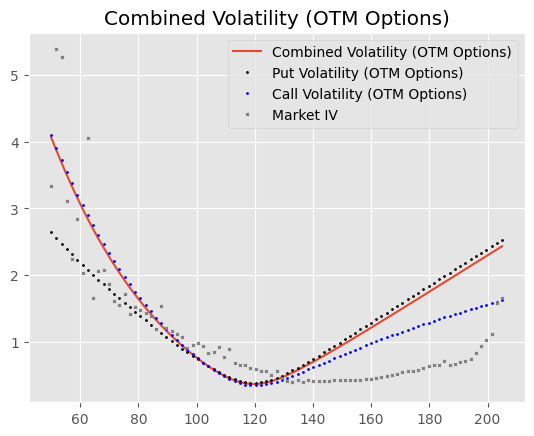

In [1159]:
range_ = np.linspace(min(K), max(K), 87)
def w(k, s0):
    m = np.log(k/s0)
    return 1/(1+np.exp(4*m))

# vols_itm_combined =( (1-w(range_, spot)) * (put_svijw(K = range_)/T[0])**0.5) + ((w(range_, spot)) * (call_svijw(K = range_)/T[0])**0.5)
# vols_otm_combined =( (1-w(range_, spot)) * (call_svijw(K = range_)/T[0])**0.5) + ((w(range_, spot)) * (put_svijw(K = range_)/T[0])**0.5)
# calls_vol = (call_svijw(K = range_)/T[0])**0.5
# puts_vol = (put_svijw(K = range_)/T[0])**0.5
plt.plot(range_, vols_itm_combined, label = 'Combined Volatility (OTM Options)')
plt.title('Combined Volatility (OTM Options)')
plt.plot(range_, puts_vol, label = 'Put Volatility (OTM Options)', linestyle = 'none', marker = 'o', markersize = 1, color = 'black')
plt.title('Put Volatility (OTM Options)')
plt.plot(range_, calls_vol, label = 'Call Volatility (OTM Options)', linestyle = 'none', marker = 'o', markersize = 1, color = 'blue')
plt.plot(range_, IV_, label = 'Market IV', linestyle = 'none', marker = 'x', markersize = 2, color = 'grey')
plt.title('Combined Volatility (OTM Options)')
plt.legend()

In [1072]:
len(IV_)

146

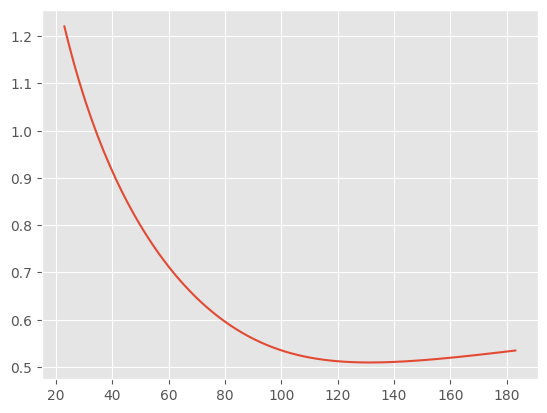

In [1078]:
((1-w(range_, spot)) * (call_svijw(K = range_)/T[0])**0.5)
vols_combined =( w(range_, spot) * (put_svijw(K = range_)/T[0])**0.5) + ((1-w(range_, spot)) * (call_svijw(K = range_)/T[0])**0.5)
plt.plot(range_, vols_combined)

In [1064]:
(call_svijw(K = range_)/T[0])**0.5

array([2.03609311, 1.89410977, 1.76312894, 1.6423583 , 1.53126714,
       1.42944486, 1.33650215, 1.25201201, 1.1754863 , 1.1063792 ,
       1.04410663, 0.98807128, 0.93768585, 0.89239091, 0.85166645,
       0.8150377 , 0.78207676, 0.75240132, 0.72567168, 0.70158692,
       0.67988077, 0.66031759, 0.6426886 , 0.62680846, 0.61251226,
       0.59965287, 0.58809872, 0.57773178, 0.56844592, 0.56014547,
       0.55274402, 0.54616329, 0.54033233, 0.53518665, 0.53066758,
       0.52672167, 0.52330018, 0.52035863, 0.51785636, 0.51575622,
       0.51402422, 0.51262926, 0.51154286, 0.51073893, 0.51019358,
       0.50988489, 0.50979279, 0.50989885, 0.51018618, 0.51063928,
       0.51124391, 0.51198702, 0.51285661, 0.51384166, 0.51493205,
       0.51611848, 0.51739241, 0.51874597, 0.52017193, 0.52166365,
       0.523215  , 0.52482037, 0.52647456, 0.52817281, 0.52991071,
       0.53168424, 0.53348965, 0.53532351, 0.53718266, 0.53906419,
       0.54096539, 0.5428838 , 0.54481713, 0.54676327, 0.54872

In [1270]:
range_ = np.linspace(0.5, 700.5, 100)
new_vols = (TotalVarSVIJW(S0, range_, T[0], *new_params)/T[0])**0.5
new_vols

import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=K, y=IV_, mode='markers', name='Market IV'))
fig.add_trace(go.Scatter(x=range_, y=new_vols, mode='lines', name='SVI IV')) 
fig.update_layout(title='Market IV vs Strike Price', xaxis_title='Strike Price', yaxis_title='Implied Volatility', height = 800, width = 800)
fig.show()

In [355]:
chain.vol.min()

0.4974784493091173